In [20]:
import time
import math
from functools import partial

import cudf
from cuml import LogisticRegression
from cuml import PCA
from cuml.preprocessing import StandardScaler
from cuml.ensemble import RandomForestClassifier
from cuml.metrics.accuracy import accuracy_score

import xgboost as xgb
import optuna

import dask
from dask.distributed import Client, LocalCluster

from sklearn.metrics import recall_score, classification_report, auc, roc_curve, ConfusionMatrixDisplay, \
    confusion_matrix

import plots

# Pre-Processing Pipeline

## Tasks

This section defines the different pre-processing steps as functions. These functions are then used to build the pre-processing pipeline later on.

In [2]:
def load_data(path):
    """
    Loads the particle dataset from a given path. Assign column names to the dataframe.
    """

    low_level_fts = ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi',
                     'jet 1 pt',
                     'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag',
                     'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi',
                     'jet 4 b-tag']
    high_level_fts = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
    columns = ["class"] + low_level_fts + high_level_fts

    df = cudf.read_csv(path)
    df.columns = columns

    # assert that df has no nan values
    assert not df.isna().values.any()

    return df


def to_float32(df, y_col):
    """
    Convert the dataframe to float32. This is necessary for GPU based inference.
    """

    x, y = df.drop(columns=y_col), df[y_col]
    x = x.astype('float32')

    df = x
    df[y_col] = y
    return df


def scale(df, y_col):
    """
    Scale the dataframe. Scaling helps to standardize the relative importance of features
    by reducing their typical (unit) sizes to a common scale across all features.
    Furthermore, scaling helps to reduce the runtime of the machine learning algorithms
    and improves convergence
    """

    x, y = df.drop(columns=y_col), df[y_col]

    scaler = StandardScaler()
    x[x.columns] = scaler.fit_transform(x[x.columns])

    df = x
    df[y_col] = y
    return df


def apply_PCA(df, n_components, y_col):
    """
    Apply PCA to the dataframe. If n_components is None, then PCA is not applied.
    
    PCA finds a linear transformation to map high-dimensional data to a lower-dimensional
    representation. The result is a set of new features (often called *components*).
    The old features are discarded. Each of the new components explains a particular amount
    of variance in the original data.
    """

    if n_components is None:
        return df

    x, y = df.drop(columns=y_col), df[y_col]

    pca = PCA(n_components=n_components)
    pca.fit(x)
    x = pca.transform(x)

    df = x
    df[y_col] = y
    return df


def split_train_valid_test(df, train_size, valid_size, test_size, shuffle=True):
    """
    Split the dataframe into train, valid and test sets.
    """

    assert math.isclose(1.0, train_size + valid_size + test_size, abs_tol=1e-9)

    # shuffle df
    if shuffle:
        df = df.sample(frac=1)

    train, valid, test = df.iloc[:int(train_size * len(df))], \
                         df.iloc[int(train_size * len(df)):int((train_size + valid_size) * len(df))], \
                         df.iloc[int((train_size + valid_size) * len(df)):]

    return train, valid, test


def split_x_y(train, valid, test, y_col):
    """
    Splits each dataframe into x and y.
    """
    train_x, train_y = train.drop(columns=[y_col]), train[y_col]
    valid_x, valid_y = valid.drop(columns=[y_col]), valid[y_col]
    test_x, test_y = test.drop(columns=[y_col]), test[y_col]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

## Pipeline

The following section defines the pre-processing pipeline using the tasks defined aboved.

In [3]:
def pipeline(params):
    df = load_data(params["path"])
    df = to_float32(df, params["class_col"])
    df = scale(df, params["class_col"])
    df = apply_PCA(df, params["n_components"], params["class_col"])
    train, valid, test = split_train_valid_test(df, params["train_size"], params["valid_size"], params["test_size"],
                                                shuffle=params["shuffle"])
    train_x, train_y, valid_x, valid_y, test_x, test_y = split_x_y(train, valid, test, y_col=params["class_col"])
    return train_x, train_y, valid_x, valid_y, test_x, test_y

The default parameters are defined as follows:

In [4]:
params = dict(
    path="data/Partical.csv",
    class_col="class",
    shuffle=True,
    n_components=None,
    train_size=0.925,
    valid_size=0.025,
    test_size=0.05,
    )

The dataset is divided into a train-, validation- and a test set, with a 92.5% / 2.5% / 5% split. Given the dataset's size, it can be assumed that 5\% of the data sufficiently represents the distribution of the whole dataset; hence, typical splits such as 80/20 are not required. 

PCA will not be applied by default. More on PCA in the evaluation section.

# Exploratory Data Analysis

The dataset consists of about 11 million observations of two types of events - background and signal. A background event is defined as all collisions that produce previously discovered particles. A signal event is defined as all collisions that produce new, undiscovered particles (or rather, their decay products). 

The observations were artificially generated using the mad-graph5 generator. Each observation consists of 21 low-level features and 7 high-level features.

The 21 low-level features are composed of properties of the decay products of the observed particles. Each observation consists of the measured kinematic properties of 4 so-called jets, which are streams of particles and a lepton, which is an elementary particle. The measured properties of the jets and the lepton include

- the momentum transverse to the beam direction, denoted as $p_{T}$ in the dataset
- the angle $\theta$ (theta)
- the angle $\phi$ (phi)

Additionally, each observation contains information on whether a jet originates from a heavy quark ($b \text{-quark}$) or other quarks and gluons; this information is referred to as the jet's $b\text{-tag}$. Each jet has 3 possible $b\text{-tags}$. Note that $b\text{-tags}$ only exist for the 4 jets, not for the lepton. 

Furthermore, each observation contains information about the energy that has been carried away by the particles. These features are denoted as \`missing energy phi' and  \`missing energy magnitude'. In addition to the 21 low-level features, there are 7 high-level features that were manually developed by physicists -  denoted as m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb.

---

The following plots are defined in a separate .py file to keep the notebook organized. The `load_data(...)` function will be used (which is why the pre-processing steps were defined before the EDA).

In [9]:
df = load_data("data/Partical.csv").to_pandas()

The class distribution is depicted in the figure below. Background events are denoted as $0.0$ and signal events as $1.0$. The class distribution is slightly skewed in favour of  the signal events. However, the imbalance is negligible. 

<Figure size 432x288 with 0 Axes>

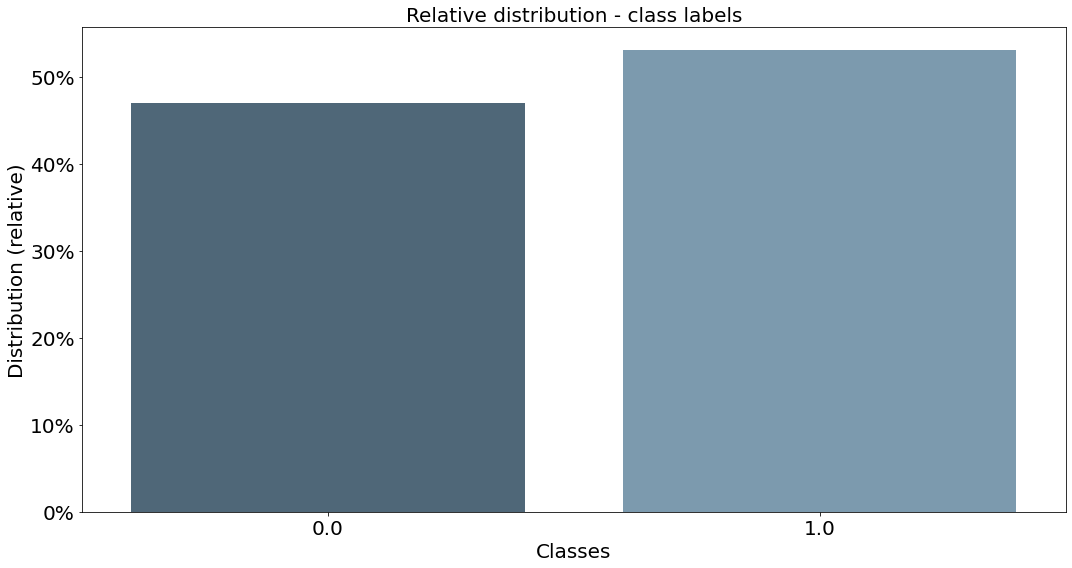

In [8]:
plots.class_balance(df)

The following three figures show the momentum, phi and theta angles of the four jets and the lepton. The distribution of each of the features is relatively similar with only minor differences with respect to the outliers.

<Figure size 432x288 with 0 Axes>

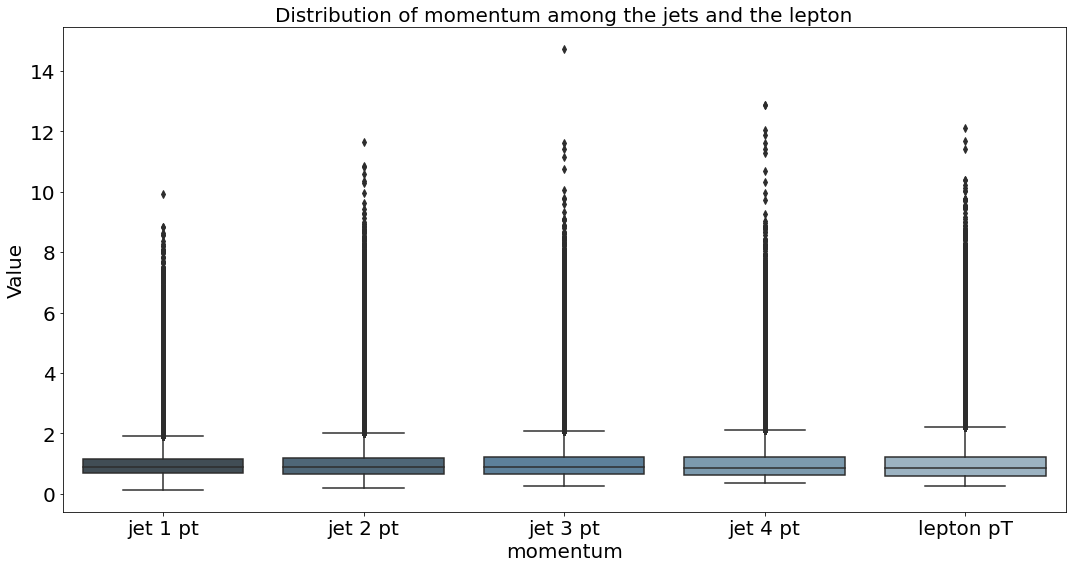

<Figure size 432x288 with 0 Axes>

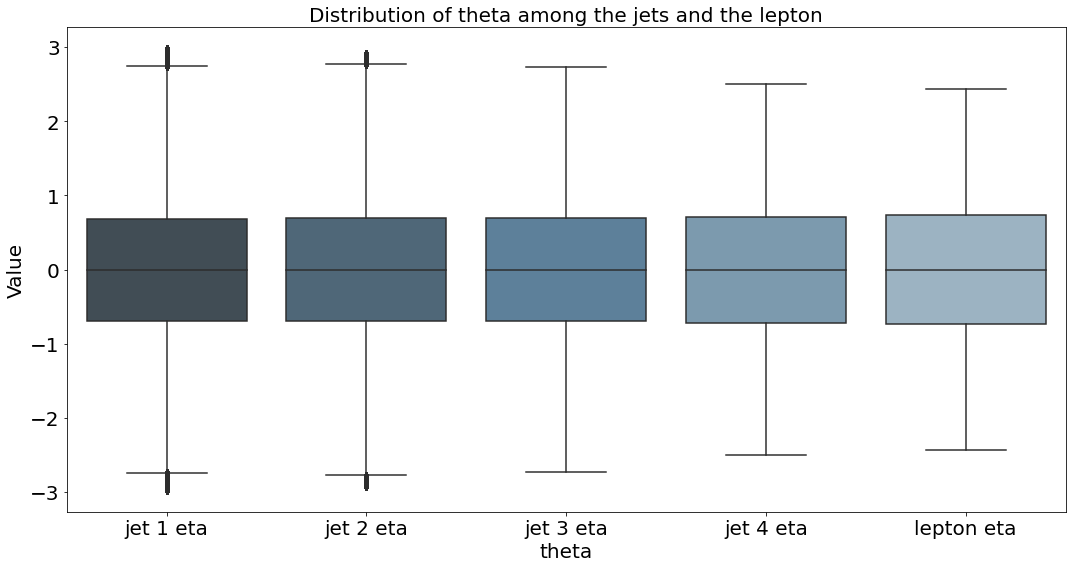

<Figure size 432x288 with 0 Axes>

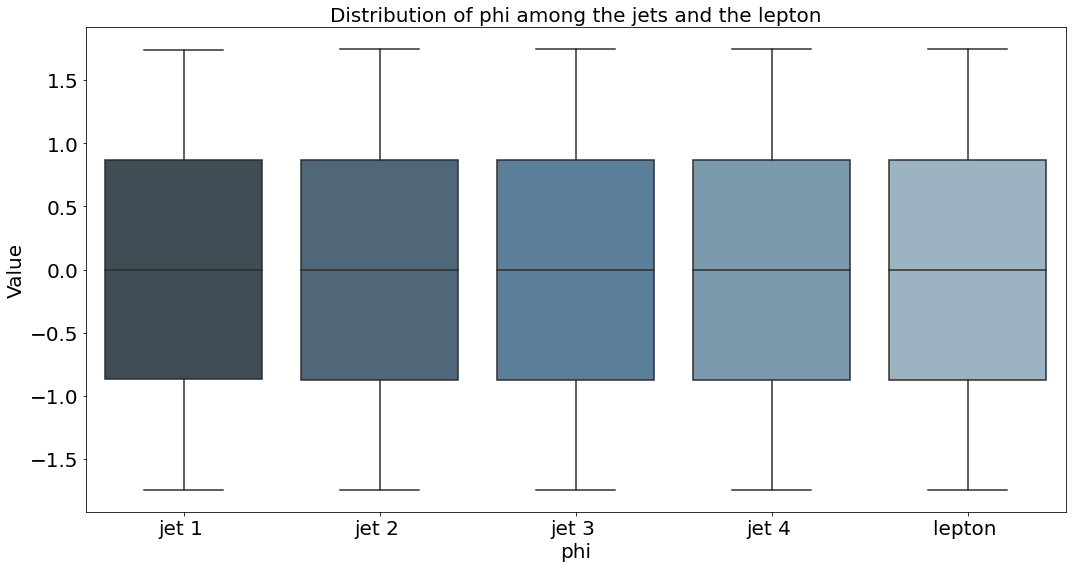

In [9]:
plots.boxplot_jets_lepton_wrapper(df)

The b-tag, which is a shared feature between the jets, is shown in the figure below. The b-tags were binned the following intervals: $[0.0, 0.0]$ (only valid for a value $=0.0$), $(1.0, 2.0]$ and $(2.0, 3.0]$ as this were the most frequent ranges within b-tags feature. Note that all jets shared values of exactly $0.0$ but had distinct values from one another within the two other intervals. It can be observed that the amount of $0.0$ b-tags increases going from jet 1 to jet 4. This is due to a slight decrease in b-tags in the $(1.0, 2.0]$ interval but mostly due to the decrease of b-tags within the $(2.0, 3.0]$ interval. Thus, despite the majority of the shared features of jets and leptons having a high correlation with respect to their distribution, the jets' b-tag shows significant dissimilarities. 

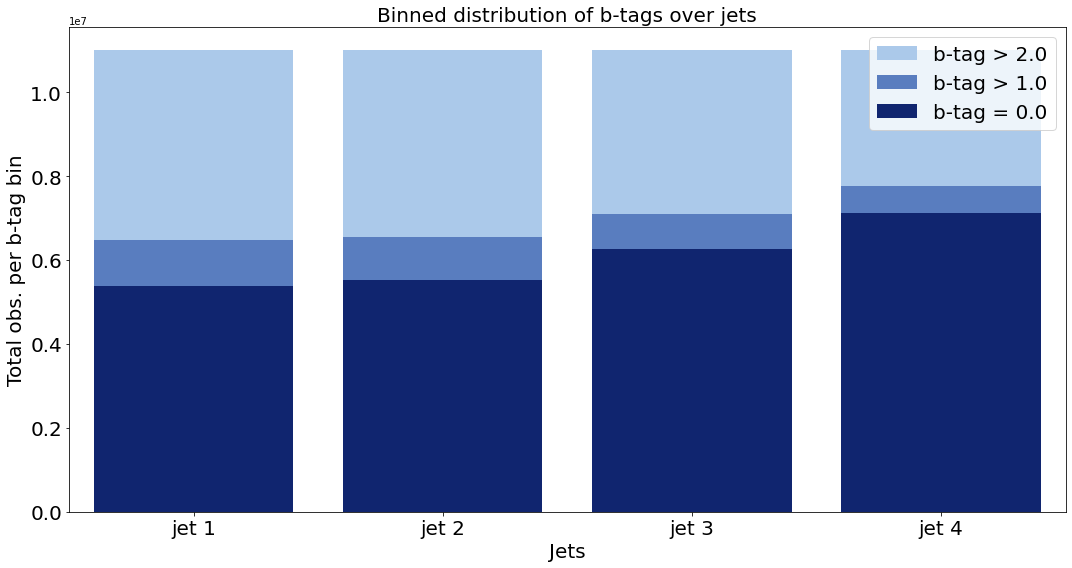

In [11]:
plots.btags(df)

The distribution of the missing energy features is illustrated in the figure below. The boxplots show a significant dissimilarity which is most likely due to both features using different units and are thus not directly comparable. The missing energy magnitude shows a significant number of outliers with values up to 15 times the median. 

<Figure size 432x288 with 0 Axes>

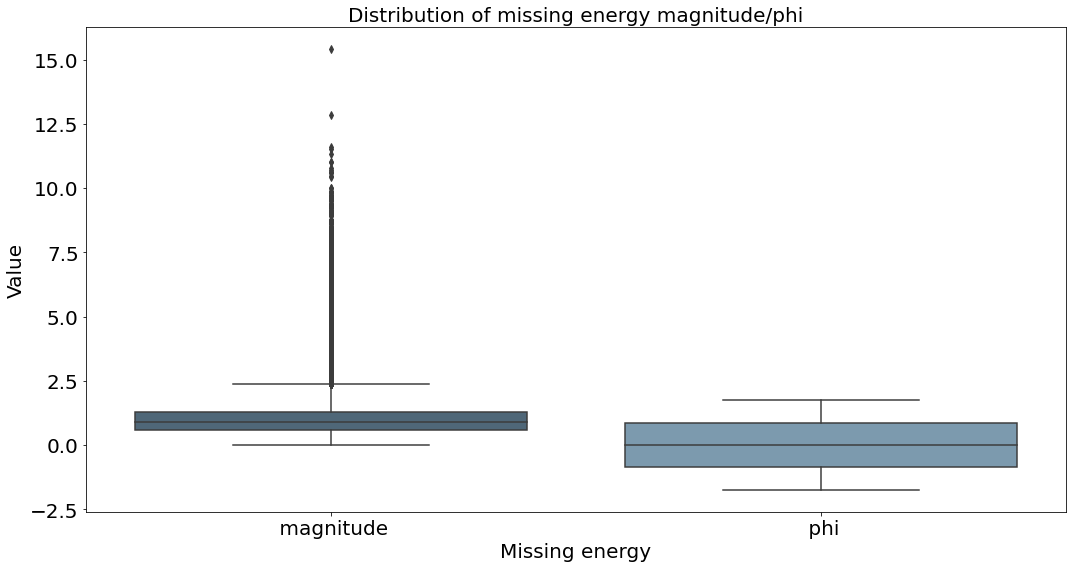

In [12]:
plots.missing_boxplot(df)

The seven high-level features are depicted in the figure below. Note that the outliers were omitted in favour of visualisation purposes. As with the missing energy distributions, the distributions of the high-level features show a significant dissimilarity. 

<Figure size 432x288 with 0 Axes>

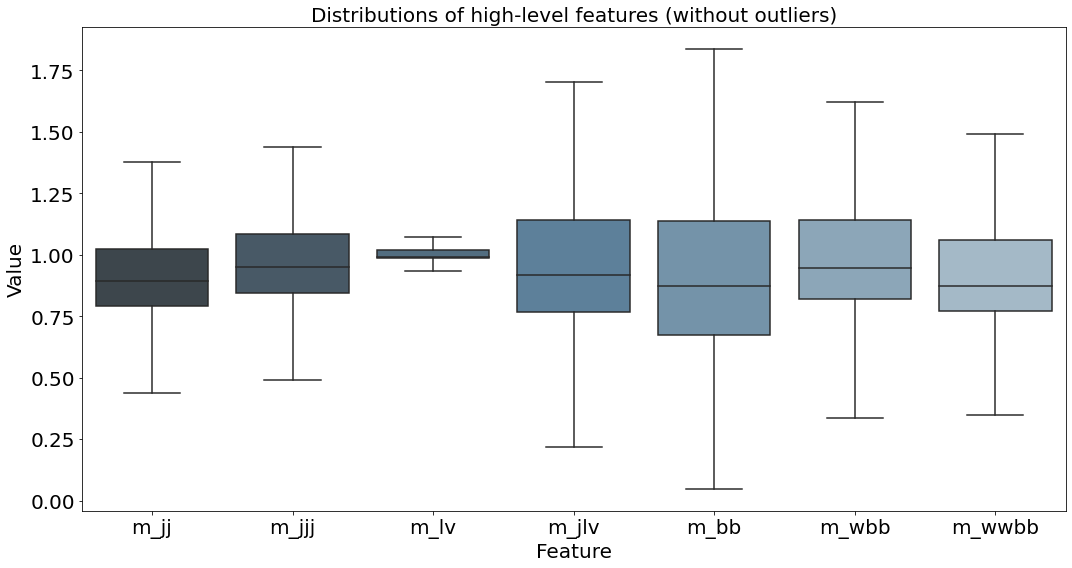

In [13]:
plots.high_level_features_boxplots(df)

Finally, the correlations between the numeric features are shown in the next figure. Note that the b-tags of the jets are considered categorical features and are, therefore, like the class labels, excluded from the correlation matrix. Note that almost no features are negatively correlated. 

Despite the similarities in the distributions of the shared features of the jets and the lepton, they do show very little correlation between each other. The only significant positive linear relationship exists between the high-level features (m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb), depicted in the lower right corner of the correlation matrix. Given the correlation between the high-level features and the magnitude of the jets and the lepton (each denoted as pt), it is likely that the features developed by the physicists are partially based on these properties. 

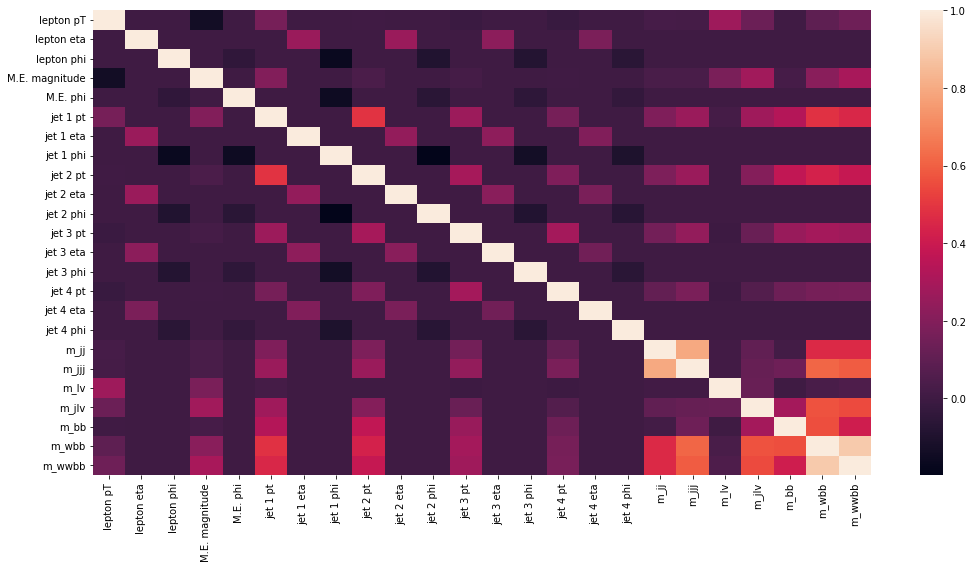

In [10]:
plots.cm(df)

# Model selection

Unfortunately, there is no way to predict which model will perform best in advance. Therefore, a variety of classifiers are tested along with a respective searchspace.

The selected classifier are Logistic Regression, Random Forest and XGBoost. SVM can not be used due to hardware limitations (runs out of GPU memory during the process). 

## Hyperparameter tuning

[Optuna](https://optuna.org/) will be used for hyperparameter tuning since it supports more advanced search algorithms and natively supports RAPIDS. 
Instead of Grid Search, the TPE (Tree-structured Parzen Estimator) Sampler will be used. Grid search is inefficient for large search spaces, and the scikit-learn implementation doesn't support RAPIDS.
The TPE Sampler utilises a standard Random Search for the first ten trials and then selects consecutive sets of hyperparameters based on a model that attempts to approximate the performance of the selected hyperparameters. 

The performance of each trial will be measured by the accuracy on the validation set. As the dataset is relatively balanced (see EDA), the accuracy is a suitable metric to compare the various optimisation trials.

The validation set will be used for evaluation rather than the test set, as the selected hyperparameters may be biased towards the subset on which they were evaluated on. 
The performance on the training set is, in general, not a good indicator for generalisation performance as the model might have been overfitted.

Besides the accuracy, additional metrics will be provided for the best performing model.

## Searchspaces

The classifiers employed, as well as their search spaces, are defined below. The `trial` argument is used by Optuna to select hyperparameters from the predefined intervals.

In [5]:
# Logistic Regression
def lr_searchspace(trial):
    return {
        "clf": LogisticRegression,
        "penalty": trial.suggest_categorical('penalty', ['l1', 'l2']),
        "C": trial.suggest_float('C', 1e-5, 1e5, log=True),
    }


# XGBoost
def xgb_searchspace(trial):
    return {
        "clf": xgb.XGBClassifier,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.4),
        'tree_method': "gpu_hist",
        'use_label_encoder': False,
        'eval_metric': 'logloss',
    }


# Random Forest
def rf_searchspace(trial):
    return {
        "clf": RandomForestClassifier,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 9),
    }

## Objective

Each Optuna trial calls the objective function. Within the objective function, a classifier is fit on the training set and evaluated on the validation set. The returned score of each trial is given by the accuracy on the validation set.

In [6]:
def objective(searchspace, x_train, y_train, x_valid, y_valid, trial):
    trial_searchspace = searchspace(trial)
    clf = trial_searchspace.pop('clf')

    model = clf(**trial_searchspace)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    return accuracy_score(y_valid, y_pred)

## Tuning

The function below wraps the Optuna hyperparameter search.

In [7]:
def run_hpo(search_space, x_train, y_train, x_valid, y_valid, n_trials):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
    study.optimize(partial(objective, search_space, x_train, y_train, x_valid, y_valid), gc_after_trial=True,
                   n_trials=n_trials, timeout=None)
                   
    print(f"Best value: {study.best_value}\n"
          f"Best params: {study.best_params}")

We can now run the pre-processing pipeline and then call the helper function on each of the search spaces/classifiers defined above. 

As a reminder, these are the pre-processing parameters defined previously:

In [8]:
params

{'path': 'data/Partical.csv',
 'class_col': 'class',
 'shuffle': True,
 'n_components': None,
 'train_size': 0.925,
 'valid_size': 0.025,
 'test_size': 0.05}

In [6]:
train_x, train_y, valid_x, valid_y, test_x, test_y = pipeline(params)

We set the number of trials to 25 for all three search spaces. Note that the first ten trials utilise regular Random Search.

In [10]:
n_trials = 25

### Logistic Regression

In [34]:
run_hpo(lr_searchspace, train_x, train_y, test_x, test_y, n_trials)

[I 2022-04-14 15:21:31,937] A new study created in memory with name: no-name-3dc88a22-86d5-477f-8812-b2087cab5a60
[I 2022-04-14 15:21:32,117] Trial 0 finished with value: 0.6360145211219788 and parameters: {'penalty': 'l2', 'C': 1.2700635099175363e-05}. Best is trial 0 with value: 0.6360145211219788.
[I 2022-04-14 15:21:32,595] Trial 1 finished with value: 0.6407982110977173 and parameters: {'penalty': 'l1', 'C': 0.00014936640578933178}. Best is trial 1 with value: 0.6407982110977173.


[W] [15:21:32.570247] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:33,748] Trial 2 finished with value: 0.641076385974884 and parameters: {'penalty': 'l2', 'C': 2141.4849632763608}. Best is trial 2 with value: 0.641076385974884.
[I 2022-04-14 15:21:34,310] Trial 3 finished with value: 0.6408600211143494 and parameters: {'penalty': 'l1', 'C': 0.00017206370402177002}. Best is trial 2 with value: 0.641076385974884.


[W] [15:21:34.286439] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:35,133] Trial 4 finished with value: 0.641294538974762 and parameters: {'penalty': 'l1', 'C': 0.0012269267006931788}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:35.108619] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:35,620] Trial 5 finished with value: 0.6408218145370483 and parameters: {'penalty': 'l1', 'C': 0.0001099919656770181}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:35.597026] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:36,331] Trial 6 finished with value: 0.6409963369369507 and parameters: {'penalty': 'l2', 'C': 0.0012029071545355445}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:36.308024] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:36,959] Trial 7 finished with value: 0.6408127546310425 and parameters: {'penalty': 'l2', 'C': 0.00026760060684957585}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:36.935741] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:37,918] Trial 8 finished with value: 0.6409708857536316 and parameters: {'penalty': 'l1', 'C': 0.01704565629299306}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:37.895270] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:38,156] Trial 9 finished with value: 0.6391800045967102 and parameters: {'penalty': 'l2', 'C': 4.087283340472617e-05}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:39,246] Trial 10 finished with value: 0.6410072445869446 and parameters: {'penalty': 'l1', 'C': 4.46621454794426}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:39,979] Trial 11 finished with value: 0.641112744808197 and parameters: {'penalty': 'l2', 'C': 11825.362342130802}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:39.956327] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:40,813] Trial 12 finished with value: 0.641185462474823 and parameters: {'penalty': 'l1', 'C': 10239.430760134084}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:41,862] Trial 13 finished with value: 0.6410054564476013 and parameters: {'penalty': 'l1', 'C': 39.4443481848683}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:42,832] Trial 14 finished with value: 0.6410108804702759 and parameters: {'penalty': 'l1', 'C': 0.13739017163227343}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:43,354] Trial 15 finished with value: 0.6410090923309326 and parameters: {'penalty': 'l1', 'C': 94620.70568510437}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:43.331024] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:43,832] Trial 16 finished with value: 0.6411363482475281 and parameters: {'penalty': 'l1', 'C': 148.12650198141978}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:43.808591] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:44,257] Trial 17 finished with value: 0.6411527395248413 and parameters: {'penalty': 'l1', 'C': 0.010099007597747676}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:44,784] Trial 18 finished with value: 0.6410090923309326 and parameters: {'penalty': 'l1', 'C': 0.8834926950100132}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:44.761430] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:45,471] Trial 19 finished with value: 0.6410054564476013 and parameters: {'penalty': 'l1', 'C': 301.9699808926056}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:45.447850] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:46,438] Trial 20 finished with value: 0.6410145163536072 and parameters: {'penalty': 'l1', 'C': 8.494743617715645}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:46.414907] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:47,505] Trial 21 finished with value: 0.640963613986969 and parameters: {'penalty': 'l1', 'C': 0.008407288204565436}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:47.477224] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:48,367] Trial 22 finished with value: 0.6411508917808533 and parameters: {'penalty': 'l1', 'C': 0.00592997046286408}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:48.343906] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


[I 2022-04-14 15:21:49,510] Trial 23 finished with value: 0.6409836411476135 and parameters: {'penalty': 'l1', 'C': 0.09791219514951881}. Best is trial 4 with value: 0.641294538974762.
[I 2022-04-14 15:21:50,065] Trial 24 finished with value: 0.6412909030914307 and parameters: {'penalty': 'l1', 'C': 0.001840914657337644}. Best is trial 4 with value: 0.641294538974762.


[W] [15:21:50.042423] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)
Best value: 0.641294538974762
Best params: {'penalty': 'l1', 'C': 0.0012269267006931788}


As we can see, the different trials achieved very similar accuracy scores, with the highest being around 64%.

### Random Forest

In [14]:
run_hpo(rf_searchspace, train_x, train_y, test_x, test_y, n_trials)

[I 2022-04-14 15:29:31,953] A new study created in memory with name: no-name-0aded026-7ab3-4685-add4-3d4f9e3cf0da
[I 2022-04-14 15:30:15,410] Trial 0 finished with value: 0.7200400233268738 and parameters: {'n_estimators': 165, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.7200400233268738.
[I 2022-04-14 15:30:50,926] Trial 1 finished with value: 0.7106963396072388 and parameters: {'n_estimators': 147, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.7200400233268738.
[I 2022-04-14 15:31:34,299] Trial 2 finished with value: 0.7058290839195251 and parameters: {'n_estimators': 188, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.7200400233268738.
[I 2022-04-14 15:32:15,110] Trial 3 finished with value: 0.7275745272636414 and parameters: {'n_estimators': 142, 'max_depth': 14, 'min_samples_split': 6}. Best is trial 3 with value: 0.7275745272636414.
[I 2022-04-14 15:33:02,501] Trial 4 finished with value: 0.660841822624

Best value: 0.7443509101867676
Best params: {'n_estimators': 159, 'max_depth': 20, 'min_samples_split': 3}


In contrast to the logistic regression, the random forest algorithm is more sensitive to hyperparameter changes. The best trial achieved an accuracy of around 74%, which is about 10% more than the logistic regression.

### XGBoost

In [11]:
run_hpo(xgb_searchspace, train_x, train_y, test_x, test_y, n_trials)

[I 2022-04-14 16:43:41,768] A new study created in memory with name: no-name-e7624690-9ea5-4e1d-8dce-fa3664fc5544
[I 2022-04-14 16:45:13,907] Trial 0 finished with value: 0.7673327326774597 and parameters: {'n_estimators': 221, 'max_depth': 14, 'min_child_weight': 2, 'learning_rate': 0.20785307508995754}. Best is trial 0 with value: 0.7673327326774597.
[I 2022-04-14 16:45:21,536] Trial 1 finished with value: 0.7494817972183228 and parameters: {'n_estimators': 272, 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.22200841167428115}. Best is trial 0 with value: 0.7673327326774597.
[I 2022-04-14 16:51:59,390] Trial 2 finished with value: 0.7652890682220459 and parameters: {'n_estimators': 286, 'max_depth': 19, 'min_child_weight': 8, 'learning_rate': 0.32324936378858227}. Best is trial 0 with value: 0.7673327326774597.
[I 2022-04-14 16:56:42,582] Trial 3 finished with value: 0.7654181718826294 and parameters: {'n_estimators': 137, 'max_depth': 18, 'min_child_weight': 2, 'learning_

Best value: 0.7708309292793274
Best params: {'n_estimators': 204, 'max_depth': 18, 'min_child_weight': 5, 'learning_rate': 0.10782755525488474}


The XGBoost achieved the best accuracy out of all selected algorithms, with an accuracy of around 77% on the validation set. The best (with respect to the chosen search space) XGBoost parameters are:

In [5]:
hpo_params = {
    'n_estimators': 204,
    'max_depth': 18,
    'min_child_weight': 5,
    'learning_rate': 0.10782755525488474,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
}

The final results are:

Logistic Regression: ~64% acc.

Random Forest: ~74% acc.

XGBoost: ~77% acc.

# Evaluation

This section will 

1. demonstrate the performance advantage of using a GPU accelerated implementation over a (distributed) CPU implementation
2. provide the performance of the model on the test set (including additional metrics)

## Comparison: training on GPU vs CPU

This section will compare the performance of XGBoost's GPU-accelerated implementation to that of XGBoost's Dask implementation. 

Both classifiers will use the default parameters and will only differ in the used tree method ("gpu_hist" for the GPU and "hist" for the CPU).

In [11]:
shared_perf_params = {
    'use_label_encoder': False,
    'eval_metric': 'logloss',
}

gpu_perf_params = {**shared_perf_params, **{"tree_method": "gpu_hist"}}
cpu_perf_params = {**shared_perf_params, **{"tree_method": "hist"}}

### GPU

In [13]:
%%timeit -n 1 -r 1 # one loop, one repetition

clf_gpu = xgb.XGBClassifier(**gpu_perf_params)
clf_gpu.fit(train_x, train_y)

3.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The GPU accelerated XGBoost implementation takes around 3 seconds to complete the training cycle.

### CPU

Because the data is presently stored in a cudf dataframe, it must be converted to a Dask-compliant format in order to use the Dask version of XGBoost. 

In [14]:
train_x_dask = dask.dataframe.from_pandas(train_x.to_pandas(), npartitions=100)
train_y_dask = dask.dataframe.from_pandas(train_y.to_pandas(), npartitions=100)

We can now initialise the cluster.

In [15]:
cluster = LocalCluster()
client = Client(cluster)

and then run one training cycle

In [16]:
%%timeit -n 1 -r 1

clf_cpu = xgb.dask.DaskXGBClassifier(**cpu_perf_params)
clf_cpu.client = client
clf_cpu.fit(train_x_dask, train_y_dask)

[12:32:37] task [xgboost.dask]:tcp://127.0.0.1:42935 got new rank 0
[12:32:37] task [xgboost.dask]:tcp://127.0.0.1:46811 got new rank 1
[12:32:37] task [xgboost.dask]:tcp://127.0.0.1:46193 got new rank 2
[12:32:37] task [xgboost.dask]:tcp://127.0.0.1:37929 got new rank 3
[12:32:37] task [xgboost.dask]:tcp://127.0.0.1:44839 got new rank 4


38.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The Dask implementation of XGBoost takes around 38 seconds, so about 12 times longer than the GPU accelerated implementation!

## Performance on the test set

Until now, we evaluated the model and its hyperparameter on the validation set only. As the hyperparameter optimisation is now complete, we can merge the train- and validation and retrain the model afterwards (with the optimal hyperparameters). The model will then be evaluated on the test set.

Merge train and validation set

In [7]:
train_x = cudf.concat([train_x, valid_x])
train_y = cudf.concat([train_y, valid_y])

The obtained optimal hyperparameter (within the defined searchspace) were:

In [8]:
hpo_params

{'n_estimators': 204,
 'max_depth': 18,
 'min_child_weight': 5,
 'learning_rate': 0.10782755525488474,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

To utilise the GPU, we set the tree method accordingly.

In [9]:
hpo_params["tree_method"] = "gpu_hist"

Retrain the model with the optimal parameters. Note that the high maximal depth is a very computational expensive parameter and leads to longer training cycles.

In [10]:
start = time.time()

clf = xgb.XGBClassifier(**hpo_params)
clf.fit(train_x, train_y)

print(f"Training took {round((time.time() - start), 2)} seconds")

Training took 344.1 seconds


Training the model took 5min 44s on the GPU. We can now use the trained model for inference and report the performance on the test set.

In [11]:
pred_y = clf.predict(test_x)

We convert the test_y to a NumPy array to calculate various metrics.

In [12]:
test_y = test_y.to_numpy()

In [13]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.76      0.75      0.75    258984
         1.0       0.78      0.79      0.78    291016

    accuracy                           0.77    550000
   macro avg       0.77      0.77      0.77    550000
weighted avg       0.77      0.77      0.77    550000



As we can see, the accuracy on the test set is no different from the one on the validation set. Considering the size of the dataset, this was expected. 

An accuracy of 77% was achieved, along with precision and recall values between 75% to 79%. 
Both signal and background events are relatively similar with respect to the precision and recall scores. However, signal events ($1.0$) are being predicted a bit more precise than background events. 

Overall the performance is acceptable but not great — more on that in the conclusion.

Additional metrics like specificity, the confusion matrix and the AUC are obtained below.

The specificity can be obtained by defining the pos_label in the recall function as it's the recall of the negative class:

In [14]:
print(f"Specificity: {recall_score(test_y, pred_y, pos_label=0)}")

Specificity: 0.7466021066938499


Confusion matrix:

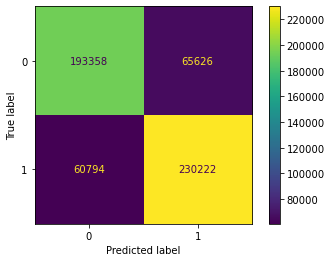

In [15]:
cm = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_y, pred_y),
)
cm.plot()

AUC

In [18]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)

In [19]:
print(f"AUC: {auc(fpr, tpr)}")

AUC: 0.76884975170028


The AUC is close to what the [authors](https://arxiv.org/pdf/1402.4735.pdf) of the dataset achieved using boosted decision trees. 

# Comparison PCA vs no PCA

Now that we know the performance on the test set, we can check whether applying PCA to the dataset yields better results.

We will utilise the `n_components` parameter of the pre-processing pipeline defined previously.

Two settings are tested: 21 principal components and 7 principal components, as this equals the number of low-level and high-level features, respectively.

### 21 principal components

In [32]:
pre_processing_params = dict(
    path="data/Partical.csv",
    class_col="class",
    shuffle=True,
    n_components=21,
    train_size=0.925,
    valid_size=0.025,
    test_size=0.05,
)

Process the data with the new parameters

In [33]:
train_x, train_y, valid_x, valid_y, test_x, test_y = pipeline(pre_processing_params)

Concat train and validation set

In [40]:
train_x = cudf.concat([train_x, valid_x])
train_y = cudf.concat([train_y, valid_y])

Make sure PCA was applied successfully by checking the number of features (which should equal 21)

In [36]:
train_x.shape

(10449999, 21)

Fit classifier

In [35]:
start = time.time()

clf = xgb.XGBClassifier(**hpo_params)
clf.fit(train_x, train_y)

print(f"Training took {round((time.time() - start), 2)} seconds")

Training took 312.37 seconds


In [37]:
pred_y = clf.predict(test_x)

In [38]:
test_y = test_y.to_numpy()

In [39]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70    258584
         1.0       0.73      0.78      0.75    291416

    accuracy                           0.73    550000
   macro avg       0.73      0.73      0.73    550000
weighted avg       0.73      0.73      0.73    550000



As we can see, applying PCA with 21 principal components resulted in a minor model-performance drop compared to the performance on the original feature set. 

The runtime was reduced by 30 seconds, or around 9%, due to the lower number of features. 

One could favour runtime performance over model performance depending on the use case. However, in this case, the runtime improvements are negligible as they are very tiny and yield a lower model-performance.

### 7 PCA components

In [41]:
pre_processing_params = dict(
    path="data/Partical.csv",
    class_col="class",
    shuffle=True,
    n_components=7,
    train_size=0.925,
    valid_size=0.025,
    test_size=0.05,
)

Process the data with the new parameters

In [42]:
train_x, train_y, valid_x, valid_y, test_x, test_y = pipeline(pre_processing_params)

Concat train and validation set

In [43]:
train_x = cudf.concat([train_x, valid_x])
train_y = cudf.concat([train_y, valid_y])

Make sure PCA was applied successfully by checking the number of features (which should equal 7)

In [45]:
train_x.shape

(10449999, 7)

Fit classifier

In [46]:
start = time.time()

clf = xgb.XGBClassifier(**hpo_params)
clf.fit(train_x, train_y)

print(f"Training took {round((time.time() - start), 2)} seconds")

Training took 151.57 seconds


In [47]:
pred_y = clf.predict(test_x)

In [48]:
test_y = test_y.to_numpy()

In [49]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.63      0.57      0.60    258455
         1.0       0.65      0.71      0.68    291545

    accuracy                           0.64    550000
   macro avg       0.64      0.64      0.64    550000
weighted avg       0.64      0.64      0.64    550000



The model performance is reduced significantly compared to the original feature set and 21 principal components. The runtime was also reduced by ~56%, which is a huge improvement. 

However, the performance is now on par with the performance of the logistic regression (see above). If the runtime is that important, one might as well stick to the logistic regression, which has a runtime that is even less than the one presented here. Even on the original feature set. 

# Conclusion

This notebook utilises the RAPIDS suite and other GPU accelerated libraries to process a large dataset and tune and train several classifiers. 

After defining the pre-processing tasks and pipeline, an exploratory data analysis was performed. Following that, Optuna was utilised to tune the parameters of the selected machine learning algorithms. 

Then, the runtime of GPU-accelerated training cycles was compared to that of a (distributed) CPU implementation. Finally, the model and the set of hyperparameters obtained from the hyperparameter optimisation were retrained, and various metrics were reported. 

Additionally, it was investigated whether or not the application of PCA yields improved performance. 

Overall the performance is acceptable but not great. This is most likely because the selected machine learning algorithms are not capable of identifying additional 'features' that describe the underlying characteristics of the data on their own.

It is very likely (and already evident) that deep learning can help improve performance due to its ability to identify additional 'features' itself automatically. Deep learning profits more than other machine learning algorithms from a large number of training samples. Since the data is simulated, it is relatively easy to generate more training data. This could allow for much deeper and more flexible networks, capable of identifying very complex patterns and ultimately leading to an outstanding performance (provided that the data captures the underlying relationship). 